```{=typst} 
#pagebreak()
```

## Abstract
Stroke is a leading cause of disability and mortality worldwide. Early identification of individuals at risk can significantly improve clinical outcomes through timely intervention. This project aims to develop a machine learning pipeline to predict the likelihood of stroke occurrence based on a patient's clinical and lifestyle attributes. Using the publicly available Stroke Prediction Dataset from Kaggle, which includes 11 features such as age, hypertension, heart disease, BMI, and smoking status, we apply supervised learning techniques to classify whether a patient is at risk of stroke.

The dataset is split into training, validation, and testing sets using a 70-15-15 ratio. Evaluation metrics, such as precision, recall, accuracy, and the F1 score for the stroke class, are used to assess model performance, with a strong emphasis on recall to minimize false negatives in a medical setting. We implement several classification models, including Logistic Regression and Random Forest, and track experiments using MLflow. The trained model is deployed via a RESTful API using FastAPI and containerized with Docker for portability.

Our best-performing model is the decision tree classifier, which achieves 89.2% accuracy, 22.9% recall, and 50% precision in the test stroke class, demonstrating its effectiveness in identifying high-risk individuals. This project also showcases a complete MLOps workflow, including data preprocessing, feature engineering, model training, experiment tracking, and deployment.


```{=typst} 
#pagebreak()
```

## Dataset
For this project, we utilize the **[Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)** from Kaggle, which is publicly available and widely used for binary classification tasks in the healthcare domain. The dataset aims to support the development of machine learning models capable of predicting whether a patient is likely to experience a stroke based on various clinical and demographic features.

The dataset contains **5,110 records**, with each entry representing an individual patient's health profile. It includes **11 features** that capture relevant medical and lifestyle factors associated with stroke risk. The target variable is stroke, a binary indicator where 1 denotes that the patient has had a stroke and 0 indicates no history of stroke.

### Features
|    **Feature**    |   **Type**  |                                      **Description**                                      |
|:-----------------:|:-----------:|:-----------------------------------------------------------------------------------------:|
| gender            | Categorical | Patient’s gender: "Male", "Female", or "Other"                                            |
| age               | Numerical   | Patient’s age in years                                                                    |
| hypertension      | Binary      | 1 if the patient has hypertension, otherwise 0                                            |
| heart_disease     | Binary      | 1 if the patient has a heart condition, otherwise 0                                       |
| ever_married      | Categorical | Marital status: "Yes" or "No"                                                             |
| work_type         | Categorical | Type of employment: "children", "Govt_job", "Never_worked", "Private", or "Self-employed" |
| Residence_type    | Categorical | Indicates whether the patient lives in a "Rural" or "Urban" area                          |
| avg_glucose_level | Numerical   | Average blood glucose level (measured in mg/dL)                                           |
| bmi               | Numerical   | Body Mass Index (BMI) of the patient                                                      |
| smoking_status    | Categorical | Smoking behavior: "formerly smoked", "never smoked", "smokes", or "Unknown"               |
| stroke            | Binary      | Target variable: 1 if the patient has had a stroke, otherwise 0                           |

: {tbl-colwidths="[20,20,60]"}

```{=typst} 
#pagebreak()
```

## Data Analysis
For the data analysis, we has explored the dataset to understand its structure, distribution of features, and relationships between them. The analysis includes:

### Dataset Overview

The dataset contains 5,110 entries. As shown in the summary above, some fields need preprocessing, especially the missing values in the `bmi` column. The `stroke` column is our target variable, showing whether a patient has had a stroke. Since the dataset isn’t ready to use as-is, we’ll need to go through several preprocessing steps first.

In [4]:
import pandas as pd

from stroke_prediction.config import RAW_DATA_DIR

data = pd.read_csv(RAW_DATA_DIR / "healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Numerical Data
We also have several numerical features that will be important for our model, such as age (ranging from 0 to 80 years), average blood glucose level (`avg_glucose_level`), and body mass index (`bmi`), which ranges from 10.3 to 97.6.

In [12]:
numeric_columns = ["age", "avg_glucose_level", "bmi"]

data.drop(columns=["id"], inplace=True, errors="ignore")
data[numeric_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


```{=typst} 
#pagebreak()
```

The `bmi` column has some missing values, and several numerical features show skewed distributions. We'll handle the missing values and apply transformations if needed. In particular, the `avg_glucose_level` column has a non-normal distribution that we’ll also address during preprocessing.

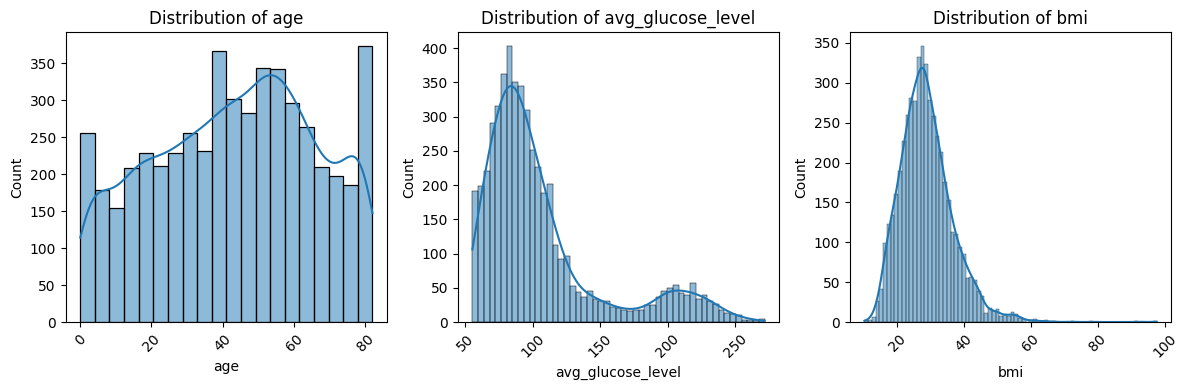

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Categorical Data
The dataset contains several categorical features, including `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, and `smoking_status`. Some of them is already the boolean type such as `hypertension` and `heart_disease`, while others are strings that will need to be encoded into numerical values for our machine learning models.

In [ ]:
data["hypertension"] = data["hypertension"].astype("bool")
data["heart_disease"] = data["heart_disease"].astype("bool")
data["stroke"] = data["stroke"].astype("bool")

category_columns = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "stroke",
]
data[category_columns].describe(include="all").T

,count,unique,top,freq
gender,5110,3,Female,2994
hypertension,5110,2,False,4612
heart_disease,5110,2,False,4834
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892
stroke,5110,2,False,4861


```{=typst} 
#pagebreak()
```

### Feature Correlation
We’ll use the `dython` package to visualize correlations between features, including both numerical and categorical variables.

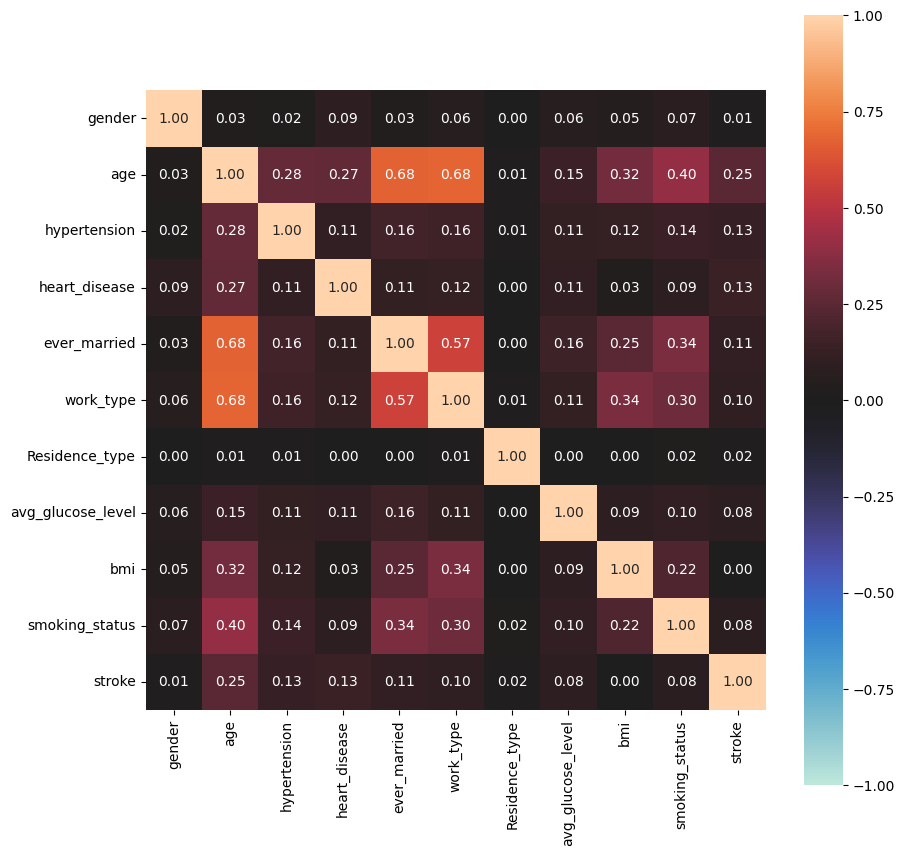

In [24]:
from dython.nominal import associations

associations(
    data,
    figsize=(10, 10),
    num_num_assoc="spearman",
);

Based on the correlation matrix, the features `gender` and `Residence_type` show little to no correlation with the target variable `stroke`. Among all features, `age` has the strongest correlation with `stroke`.

**Key Findings**

* The dataset contains 5,110 entries with various clinical attributes.
* The `bmi` and `avg_glucose_level` columns have missing values and skewed distributions.
* The target variable `stroke` is imbalanced, with far more non-stroke cases than stroke cases.
* Several categorical features are also imbalanced, including `gender`, `hypertension`, and `heart_disease`.
* `Age` shows the strongest correlation with the target variable, while `gender` and `Residence_type` show no meaningful correlation.


## Feature Engineering
In this section, we will perform feature engineering to prepare the dataset for machine learning. This includes handling missing values, encoding categorical variables.
### Data Preprocessing Steps

#### Removing Unnecessary Columns
We analyzed all columns to identify those that don’t add value to the prediction task. The following columns were removed:

* **`gender`**: Showed no significant correlation with the target variable during exploratory analysis.
* **`residence_type`**: No substantial differences in outcomes between urban and rural categories.
* **`id`**: A unique identifier with no predictive value; keeping it could introduce noise.

Removing these columns helps reduce dimensionality, improve model efficiency, and lower the risk of overfitting.

```python
X = X.drop(columns=["id", "gender", "Residence_type"])
```


#### Correcting Data Types
Some columns had incorrect data types, which could impact analysis and model training. For example:

* **`age`** was stored as a string instead of a number. We converted it to an integer after confirming all values were numeric and free of outliers.

This ensures compatibility with machine learning models that require numeric inputs for processing.

```python
X["age"] = X["age"].astype(int)
```

#### Encoding Categorical Variables
Machine learning models require numerical inputs, so we encoded categorical variables as follows:

* **Binary Encoding**:

  * **`ever_married`** (Yes/No) was encoded as 1 for "Yes" and 0 for "No".
  * Alternatively, this can be simulated using one-hot encoding by dropping the first category.

```python
X["ever_married"] = X["ever_married"].map({"Yes": 1, "No": 0})
```

* **One-Hot Encoding**:

  * Applied to features with more than two categories, such as `work_type` and `smoking_status`.
  * We used `drop_first=True` to avoid multicollinearity.
  * It’s suitable for multi-category variables, as it avoids imposing any order and allows the model to interpret each category independently.

```python
X = pd.get_dummies(X, columns=["work_type", "smoking_status"], drop_first=True)
```

```{=typst} 
#pagebreak()
```

#### Handling Missing Values
Missing values appeared only in the `bmi` column. To handle them—and to future-proof the pipeline—we used **K-Nearest Neighbors (KNN) imputation** across all features.

```python
imputer = KNNImputer(n_neighbors=5)
imputer.set_output(transform="pandas")
X_train = imputer.fit_transform(X_train)
```

*KNN Imputation Advantages:*
It estimates missing values based on similar rows (neighbors), making it more accurate than simple methods like mean imputation, especially for an important feature like `bmi`.

Finally, we combined the whole preprocessing steps into a pipeline using `sklearn`'s `Pipeline` class. This allows us to apply all transformations in a single step.

```python
pipeline = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("drop", "drop", ["id", "gender", "Residence_type"]),
                    (
                        "one_hot",
                        OneHotEncoder(sparse_output=False, drop="first"),
                        ["ever_married", "work_type", "smoking_status"],
                    ),
                ],
                remainder="passthrough",
                force_int_remainder_cols=False,
            ),
        ),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)
```

```{=typst} 
#pagebreak()
```

### Resampling the Dataset
The dataset is imbalanced, with significantly more non-stroke cases than stroke cases. To address this, we have try various resampling techniques to balance the classes by using grid search to find the best resampling combination for both over-sampling and under-sampling methods. 

#### Resampler Testing
Since our dataset is heavily imbalanced, we set out to identify the most suitable sampling methods for our project. We used GridSearch to explore all combinations of oversampling and undersampling methods within our defined sampling space, using the default parameters for each classification model of interest. We then selected the best-performing combination of sampling methods that showed consistently strong performance across all models for subsequent hyperparameter tuning.

![Resampler Testing](figures/resampler_test.png)

After running GridSearch, we found that the most effective combination was **BorderlineSMOTE** for oversampling and **NeighbourhoodCleaningRule** for undersampling.

**BorderlineSMOTE** is a variant of the SMOTE (Synthetic Minority Over-sampling Technique) algorithm designed to handle class imbalance in datasets. While standard SMOTE generates synthetic samples by interpolating between all minority class points and their nearest neighbors, BorderlineSMOTE improves this approach by focusing only on minority class samples located near the decision boundary—i.e., those most likely to be misclassified [@imblearn_borderlinesmote].


**Neighbourhood Cleaning Rule** is an undersampling technique that enhances class balance by removing majority class instances that are close to minority class instances. This reduces noise and improves the quality of the dataset [@activeloop_ncl].


```{=typst} 
#pagebreak()
```

## ML Model Development/Training
We used Optuna with its default **TPESampler** to efficiently search for the best classification model and hyperparameter combinations within the defined parameter space. To ensure reproducibility, we managed both the dataset and preprocessing pipeline using **Data Version Control (DVC)**. For tracking experiments and results, we integrated **MLflow**, which provides a robust and user-friendly interface.

### Model Prototyping

After creating the sampled dataset, we used it for further model tuning. We evaluated multiple classification models, including **CatBoost**, **Decision Tree**, **Random Forest**, a simple **Neural Network**, and **K-Nearest Neighbors (KNN)**. For each model, we identified the best-performing configuration and compared their results.

To optimize hyperparameters, we used **Optuna** with the **TPE (Tree-structured Parzen Estimator) sampler**. This algorithm guides the search process by modeling the distribution of good and bad hyperparameter values separately:

* **l(x)**: A Gaussian Mixture Model (GMM) fit to the best-performing parameter values.
* **g(x)**: A GMM fit to the remaining values.

Optuna selects parameter values that maximize the ratio **l(x)/g(x)**, effectively focusing the search on more promising areas of the parameter space. This approach allows for efficient exploration and better tuning results compared to random or grid search methods [@optuna_tpesampler].

After tuning all models, the Decision Tree model achieved the best performance on the test dataset.

![Model Tuning Results](figures/model_tuning.png)

```{=typst} 
#pagebreak()
```

### Model Evaluation
After training and tuning several classification models, we conducted a thorough evaluation using the test dataset to determine which model delivered the best performance. The goal was to compare each model’s ability to generalize to unseen data and make accurate predictions in a realistic setting.

Among all the models, the tuned Decision Tree model consistently outperformed the others on the test set. It demonstrated the best balance between accuracy, precision, recall, and F1-score, making it the most suitable candidate for deployment in this use case. This result suggests that, despite its simplicity, a well-tuned Decision Tree can be highly effective for this type of structured clinical data.

![Model Evaluation Results](figures/model_eval.png)

```{=typst} 
#pagebreak(weak:true)
```

## Containerization
We used **Python** as the primary programming language for this project. For package and project management, we adopted **UV**, a fast, modern tool that simplified development and testing. The entire project was also **containerized using Docker**, ensuring consistency and portability across different environments for deployment.

**UV** is a high-performance package manager and installer for Python, written in Rust. It serves as a drop-in replacement for tools like `pip`, offering faster installs, more reliable dependency resolution, and built-in virtual environment management. We chose UV for its ability to create lightweight, reproducible environments while maintaining compatibility with existing Python workflows.
*Reference: [DataCamp UV Tutorial](https://www.datacamp.com/tutorial/python-uv)*

**Docker** is an open platform that allows developers to package applications and their dependencies into containers. These containers provide isolated environments that can run consistently across different systems, making deployment more reliable. By using Docker, we avoided host-level dependencies and ensured the application runs the same way in every environment.
*Reference: [Docker Overview](https://docs.docker.com/get-started/docker-overview/)*


Here is the Dockerfile we used to containerize our application:

```dockerfile
# syntax=docker/dockerfile:1.3
FROM ghcr.io/astral-sh/uv:python3.12-bookworm-slim

WORKDIR /app

COPY src /app/src
COPY pyproject.toml /app/

RUN uv pip install --system --no-cache-dir .

COPY . /app/

RUN --mount=type=secret,id=aws,target=/root/.aws/credentials uv run dvc pull

EXPOSE 8000

CMD ["fastapi", "run", "--host", "0.0.0.0", "--port", "8000", "src/app/main.py"]
```

```{=typst} 
#pagebreak(weak:true)
```

We also use the docker-compose file to define the services and their configurations such as secrets, environment variables, and ports. Here is the docker-compose file we used:

```yaml
services:
  app:
    build: .
    ports:
      - "8000:8000"
    environment:
      - AWS_ACCESS_KEY_ID=${AWS_ACCESS_KEY_ID}
      - AWS_SECRET_ACCESS_KEY=${AWS_SECRET_ACCESS_KEY}
      - AWS_DEFAULT_REGION=${AWS_DEFAULT_REGION}
      - API_KEY=${API_KEY}
      - S3_BUCKET_URL=${S3_BUCKET_URL}
      - S3_ENDPOINT_URL=${S3_ENDPOINT_URL}
    env_file:
      - ./.env

secrets:
  aws:
    file: $HOME/.aws/credentials
```

## ML Model Deployment

For deploying the machine learning model, we built a RESTful API using **FastAPI**. FastAPI was chosen for its high performance and its integration with **Pydantic**, which simplifies input validation and ensures that incoming requests are correctly formatted before reaching the model.

The model itself is served using **ONNX Runtime**, which runs the model in the **ONNX** format for fast, cross-platform inference. This setup enhances prediction speed and makes the model easier to deploy across different environments.

The API includes three main routes:

* A **health** route, which provides a simple endpoint to check if the service is running properly.
* A **predict** route, which accepts input data, validates it, and returns the model’s prediction. This route requires an `x-key` header for authentication to ensure secure access.
* A **docs** route, powered by **OpenAPI**, offering automatically generated interactive API documentation for easy exploration and testing of the endpoints.

The application is containerized with **Docker** and deployed on the department’s virtual machine at `10.35.27.75:8000`. Since this VM does not have a public IP address, access to the API requires connecting through the university’s VPN for security and network access.

![Swagger UI](figures/swagger.png)

For testing the API, we used OpenAPI's interactive documentation, which allows us to send requests directly from the browser. The API accepts input data in JSON format, and we can test predictions by providing sample patient data.

![API Testing](figures/predict_test.png)

## Model Monitoring
First, we simulated real-world data based on a validated dataset. In this scenario, the new data represents a younger user aged 15–20 who has never been married. Their average glucose levels are moderately healthy, ranging between 100 and 120. They have no history of hypertension or heart disease, and their BMI falls within a healthy range of 18 to 26. A new trend has emerged in this group: boys aged 15–20 are now smoking, without exception. We are actively monitoring this data for potential drift.

![Data Drift](figures/evidently.png)

## Conclusion
This project successfully demonstrates the implementation of a complete MLOps pipeline to address a real-world healthcare problem: stroke prediction. Starting from data preprocessing and feature engineering, we tackled challenges such as missing values and class imbalance using advanced techniques like KNN imputation and BorderlineSMOTE combined with the Neighbourhood Cleaning Rule. Multiple classification models were trained and evaluated, with a tuned decision tree model emerging as the best performer. It achieved 89.2% accuracy and focused on recall to reduce false negatives, which is crucial in medical diagnostics.

To ensure reproducibility and manage the complexity of the machine learning lifecycle, we adopted tools like MLflow for experiment tracking, Optuna for hyperparameter optimization, and DVC for data versioning. The final model was deployed through a FastAPI-based RESTful API, containerized with Docker to ensure environment consistency and scalability. We also considered model monitoring through data drift detection, simulating real-world changes in patient demographics and behaviors.

Overall, this project provides a practical solution for stroke risk assessment and a robust example of how modern MLOps practices can enhance reliability, maintainability, and impact in critical domains such as healthcare.


```{=typst} 
#pagebreak(weak:true)
```
::: {#refs}
:::